# Anomaly Detection

> In this notebook, we'll implement anomaly detection in time series data

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/statsforecast/examples/getting_started_short.html)
:::

## Introduction

Anomaly detection is a crucial task in time series forecasting. It involves identifying unusual observations that don't follow the expected dataset patterns. Anomalies, also known as outliers, can be caused by a variety of factors, such as errors in the data collection process, sudden changes in the underlying patterns of the data, or unexpected events. They can pose problems for many forecasting models since they can distort trends, seasonal patterns, or autocorrelation estimates. As a result, anomalies can have a significant impact on the accuracy of the forecasts, and for this reason, it is essential to be able to identify them. Furthermore, anomaly detection has many applications across different industries, such as detecting fraud in financial data, monitoring the performance of online services, or identifying usual patterns in energy usage.

By the end of this tutorial, you'll have a good understanding of how to detect anomalies in time series data using [StatsForecast](https://nixtla.github.io/statsforecast/)'s probabilistic models.

**Outline:**

1. Install libraries
2. Load and explore data
3. Train model
4. Recover insample forecasts and identify anomalies

::: {.callout-important}

## Important

Once an anomaly has been identified, we must decide what to do with it. For example, we could remove it or replace it with another value. The correct course of action is context-dependent and beyond this notebook's scope. Removing an anomaly will likely improve the accuracy of the forecast, but it can also underestimate the amount of randomness in the data.  
:::

:::{.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
:::

## Install libraries

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html)

Install the necessary packages using `pip install statsforecast`

In [1]:
pip install statsforecast -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.8 MB/s eta 0:00:00


## Load and explore the data

For this example, we'll use the hourly dataset of the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128).

In [2]:
import pandas as pd

In [3]:
df_total = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
df_total.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `df` and `y`.  

- `unique_id`: (string, int or category) A unique identifier for the series.
- `ds`: (timestamp or int) A timestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS or an integer indexing time.
- `y`: (numeric) The measurement we wish to forecast.

From this dataset, we'll select the first 8 time series to reduce the total execution time. You can select any number you want by changing the value of `n_series`.

In [4]:
n_series = 8
uids = df_total['unique_id'].unique()[:n_series]
df = df_total.query('unique_id in @uids')

We can plot these series using the `plot_series` function from the `utilsforecast` package. This function has multiple parameters, and the required ones to generate the plots in this notebook are explained below.

- `df`: A pandas dataframe with columns [unique_id, ds, y].
- `forecasts_df`: A pandas dataframe with columns [unique_id, ds] and models.
- `ids`: A list with the ids of the time series we want to plot.
- `level`: Prediction interval levels to plot.
- `plot_anomalies`: Whether or not to include the anomalies for each prediction interval.

In [5]:
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

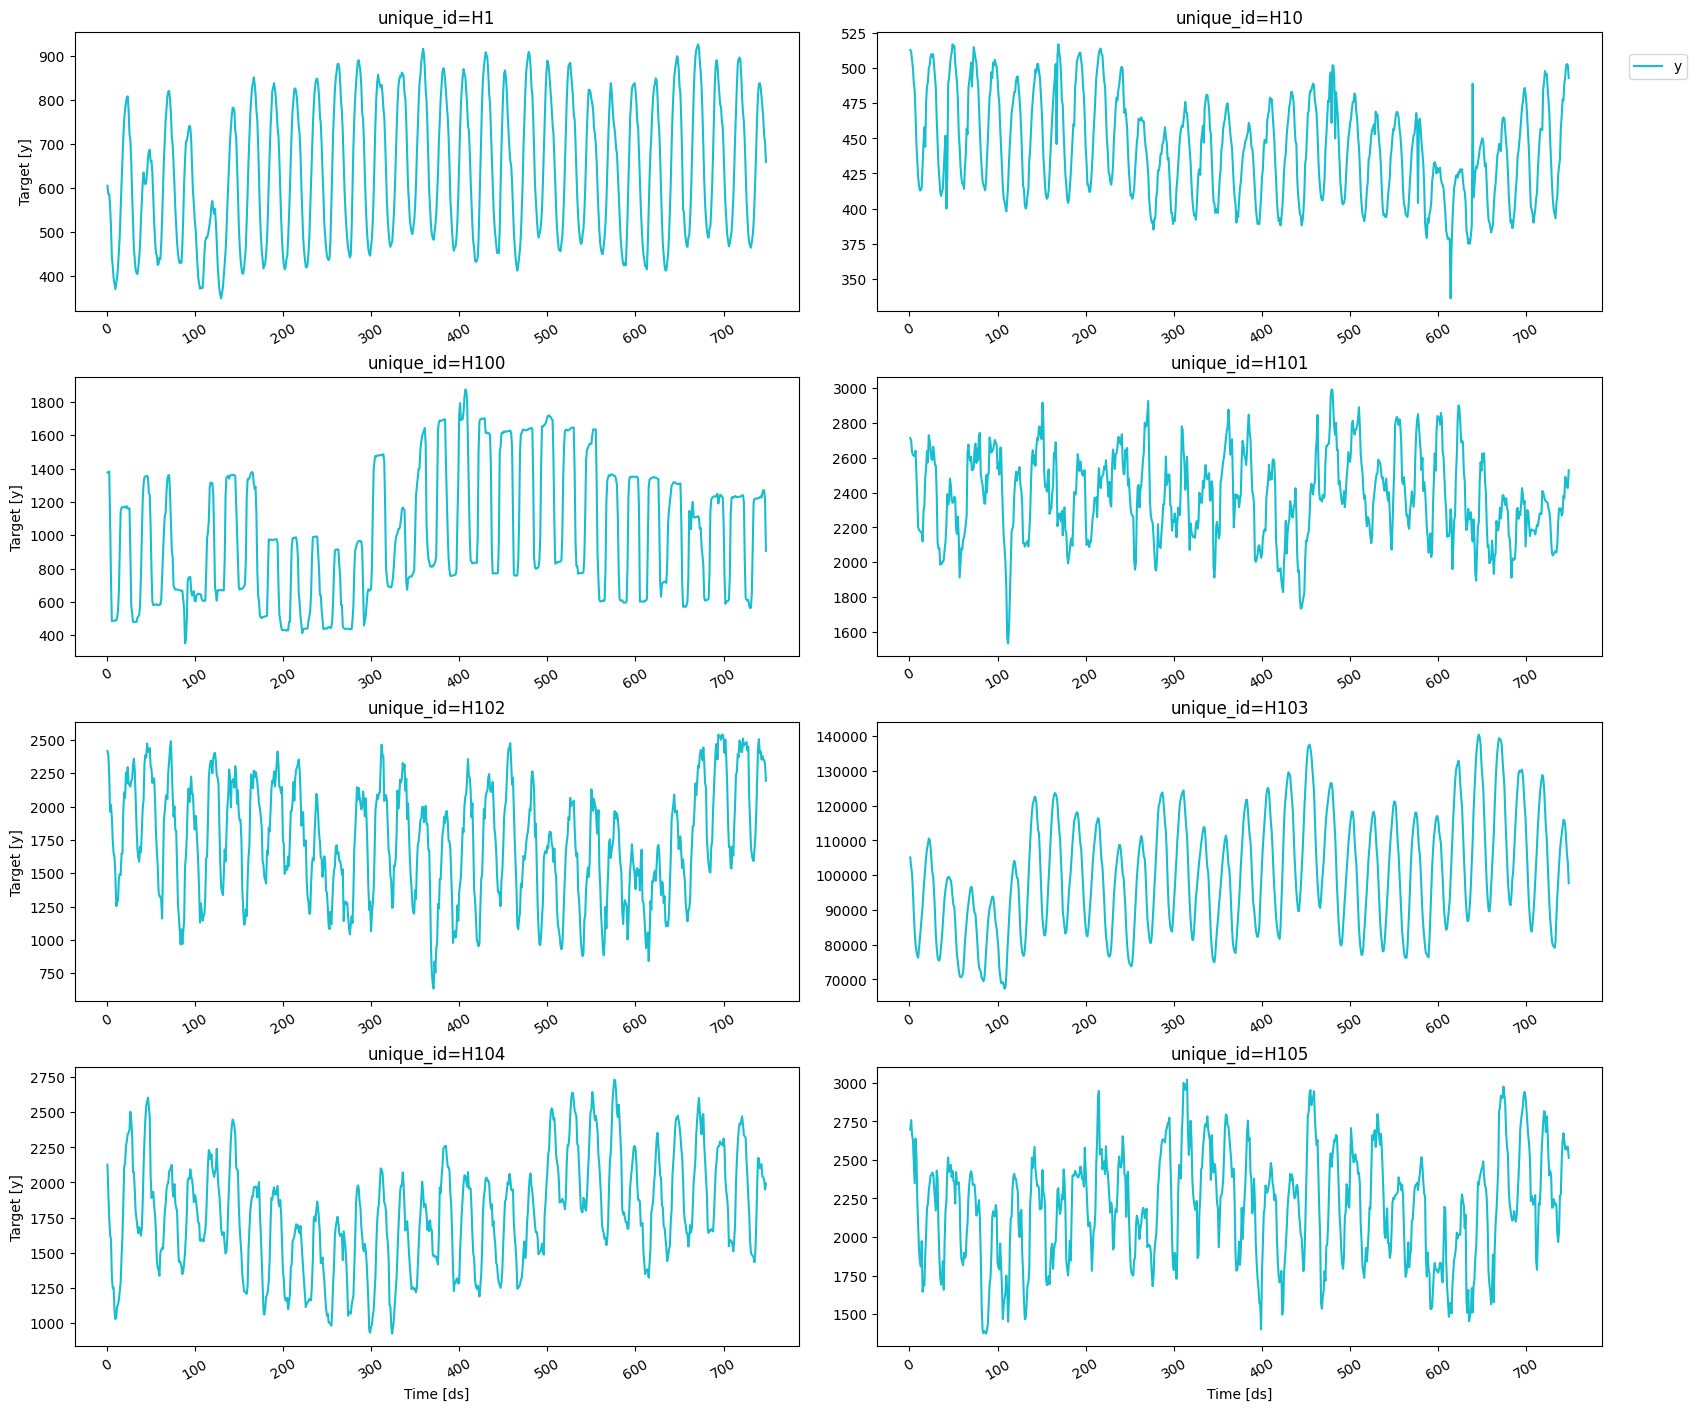

In [6]:
plot_series(df)

## Train model

To generate the forecast, we'll use the [MSTL](https://nixtla.github.io/statsforecast/models.html#multiple-seasonalities) model, which is well-suited for low-frequency data like the one used here. We first need to import it from `statsforecast.models` and then we need to instantiate it. Since we're using hourly data, we have two seasonal periods: one every 24 hours (hourly) and one every 24\*7 hours (daily). Hence, we need to set `season_length = [24, 24*7]`.

In [7]:
from statsforecast.models import MSTL

In [8]:
# Create a list of models and instantiation parameters
models = [MSTL(season_length = [24, 24*7])]

To instantiate a new StatsForecast object, we need the following parameters:

- `models`: The list of models defined in the previous step.
- `freq`: A string or integer indicating the frequency of the data. See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [9]:
sf = StatsForecast(
    models=models,
    freq=1,
    n_jobs=-1,
)

We'll now predict the next 48 hours. To do this, we'll use the `forecast` method, which requieres the following arguments:

- `df`: The dataframe with the training data.
- `h`: The forecasting horizon.
- `level`: The confidence levels of the prediction intervals.
- `fitted`: Return insample predictions.

It is important that we select a `level` and set `fitted=True` since we'll need the insample forecasts and their prediction intervals to detect the anomalies.

In [10]:
horizon = 48
levels = [99]

fcst = sf.forecast(df=df, h=48, level=levels, fitted=True)
fcst.head()

,unique_id,ds,MSTL,MSTL-lo-99,MSTL-hi-99
0,H1,749,607.607223,587.173250,628.041196
1,H1,750,552.364253,521.069710,583.658796
2,H1,751,506.785334,465.894977,547.675691
3,H1,752,472.906141,423.114088,522.698195
4,H1,753,452.240231,394.064394,510.416067


We can plot the forecasts using the `plot_series` function from before.

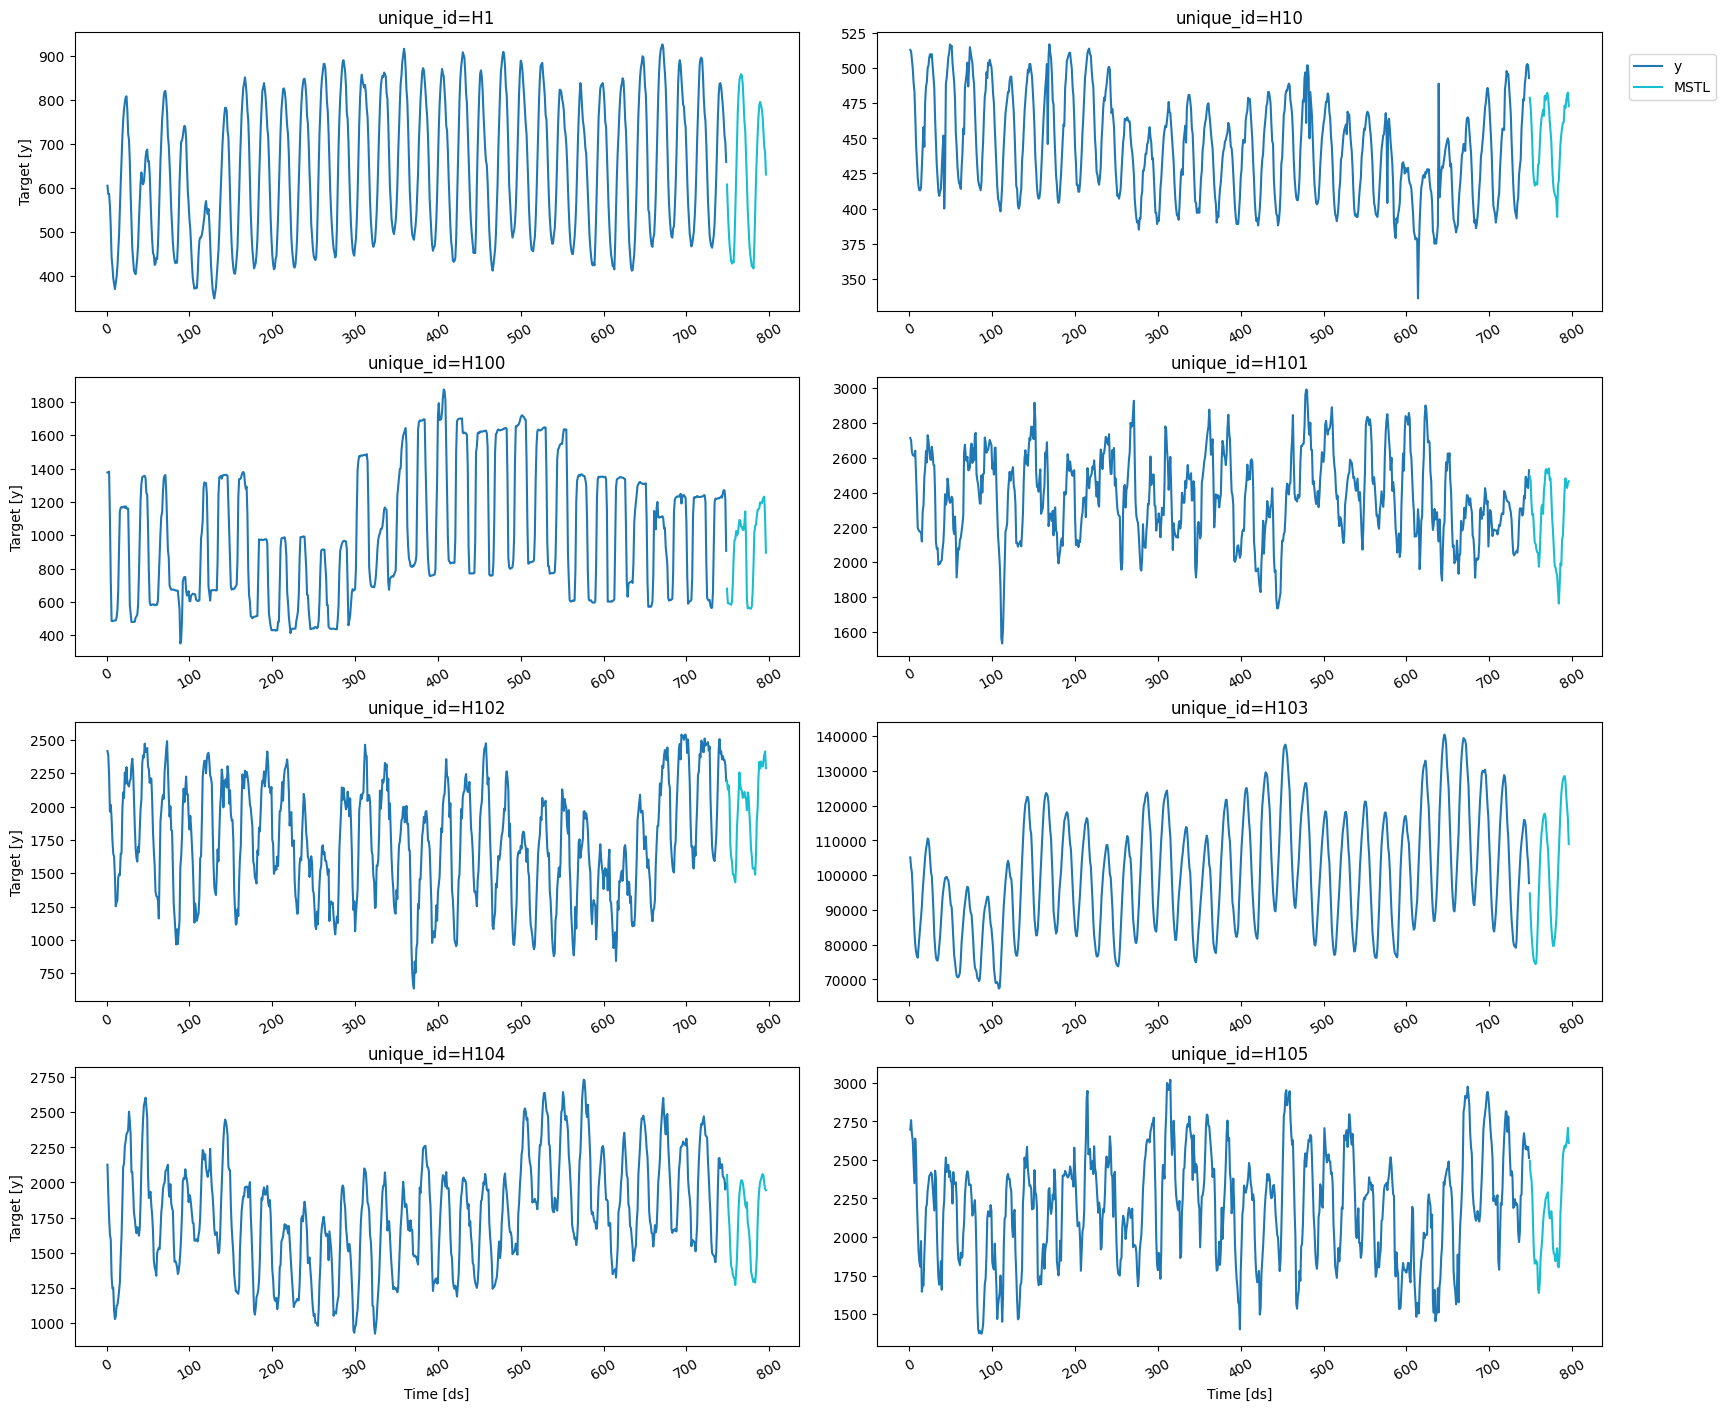

In [11]:
plot_series(df, fcst)

## Recover insample forecasts and identify anomalies

In this example, an **anomaly** will be any observation outside the prediction interval of the insample forecasts for a given confidence level (here we selected 99%). Hence, we first need to recover the insample forecasts using the `forecast_fitted_values` method.

In [12]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()

,unique_id,ds,y,MSTL,MSTL-lo-99,MSTL-hi-99
0,H1,1,605.0,605.098607,584.678408,625.518805
1,H1,2,586.0,588.496673,568.076474,608.916872
2,H1,3,586.0,585.586856,565.166657,606.007054
3,H1,4,559.0,554.012377,533.592178,574.432576
4,H1,5,511.0,510.153508,489.733309,530.573707


We can now find all the observations above or below the 99% prediction interval for the insample forecasts.

In [13]:
anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
anomalies.head()

,unique_id,ds,y,MSTL,MSTL-lo-99,MSTL-hi-99
42,H1,43,613.0,649.404871,628.984672,669.825069
47,H1,48,683.0,662.245526,641.825328,682.665725
48,H1,49,687.0,655.382320,634.962122,675.802519
100,H1,101,507.0,484.934230,464.514031,505.354428
110,H1,111,451.0,474.899006,454.478808,495.319205


We can plot the anomalies by setting the `level` and the `plot_anomalies` arguments of the `plot_series` function.

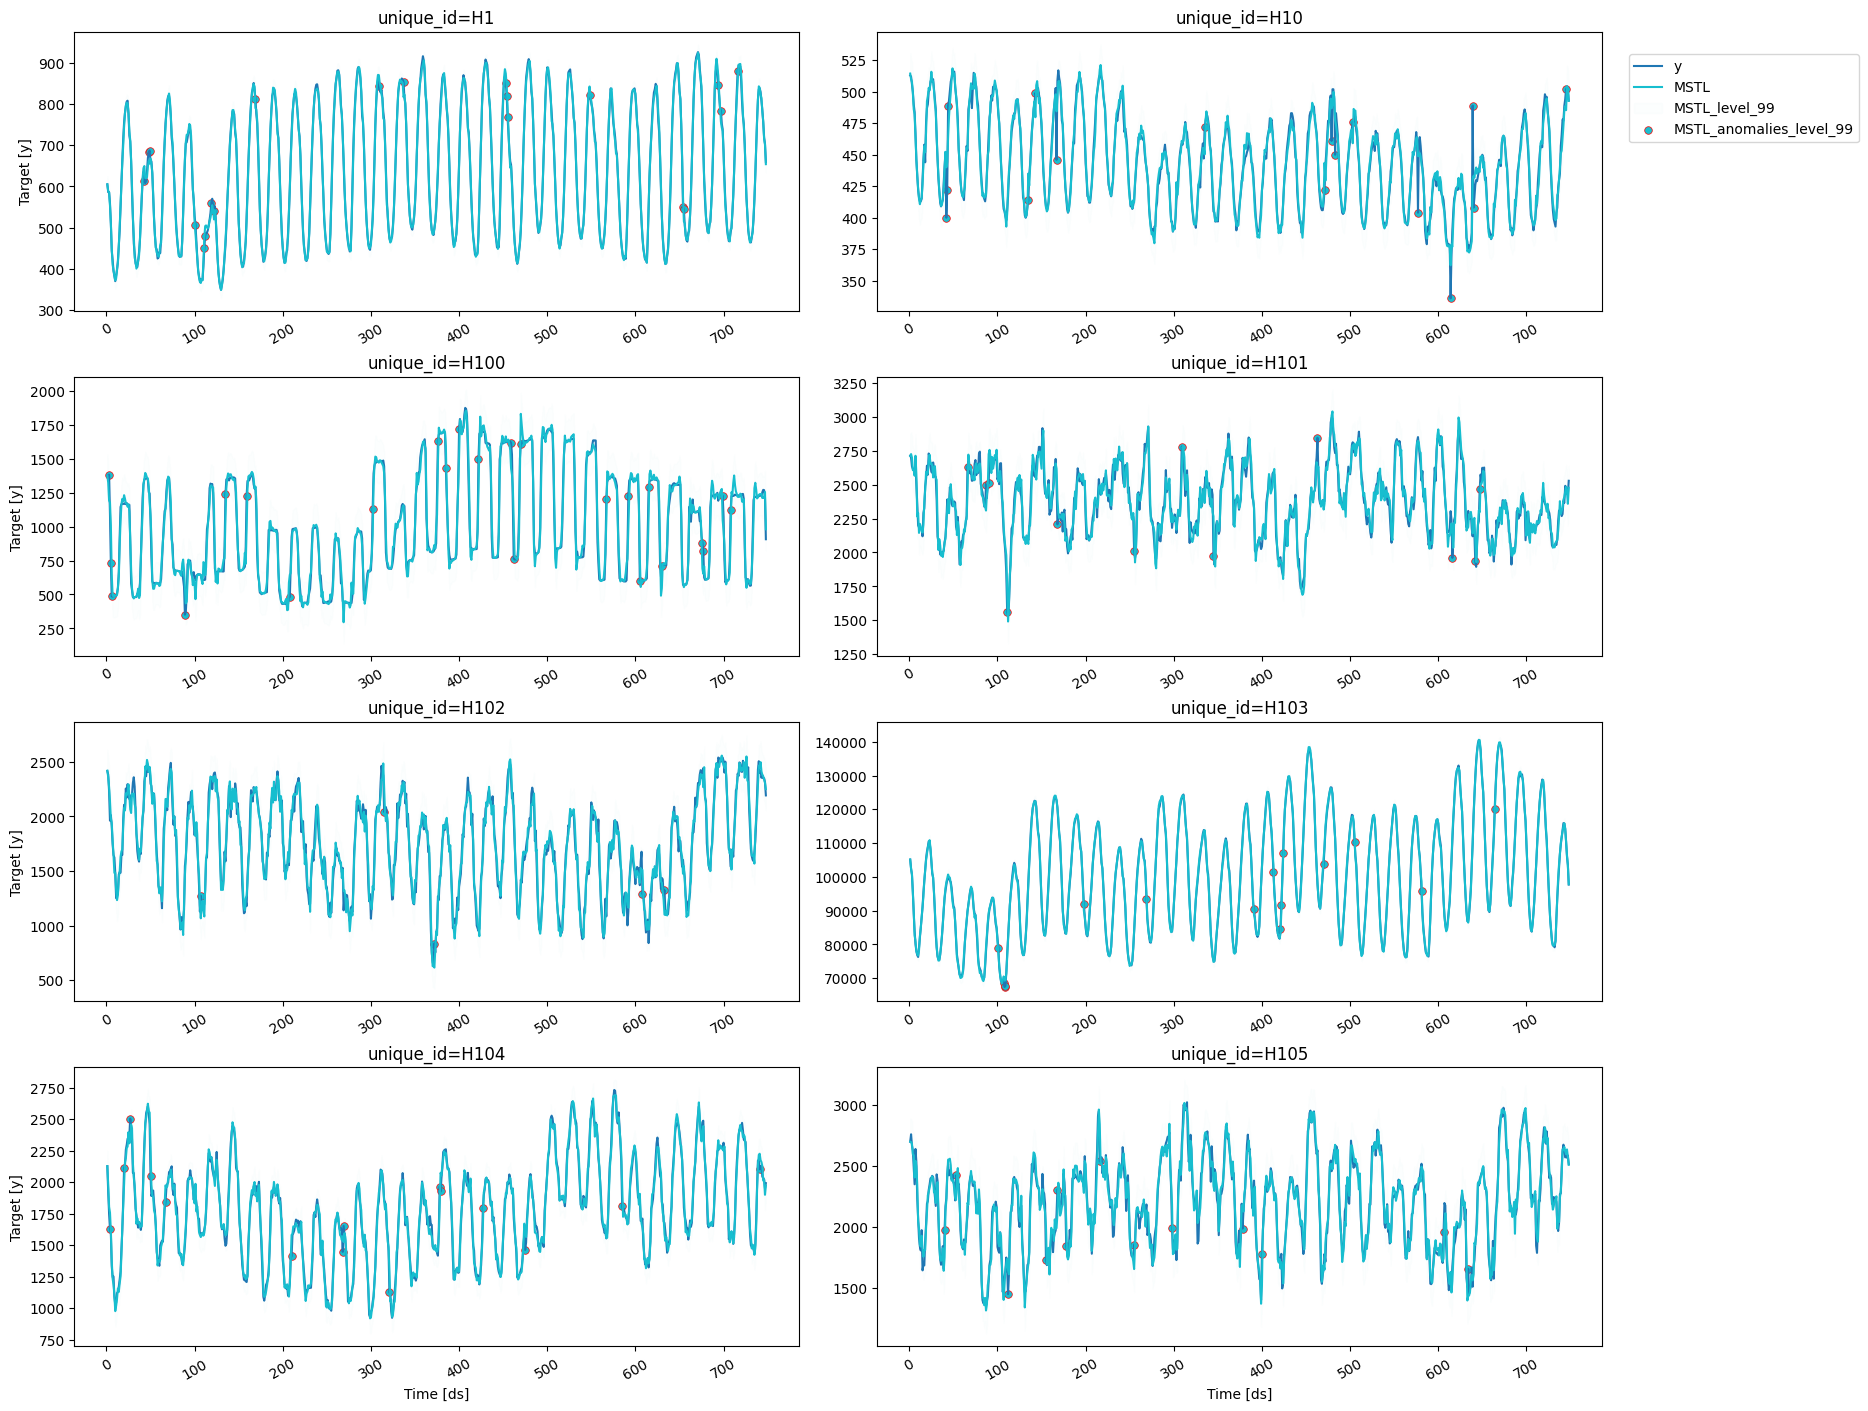

In [14]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True)

If we want to take a closer look, we can use the `ids` argument to select one particular time series, for example, `H10`.

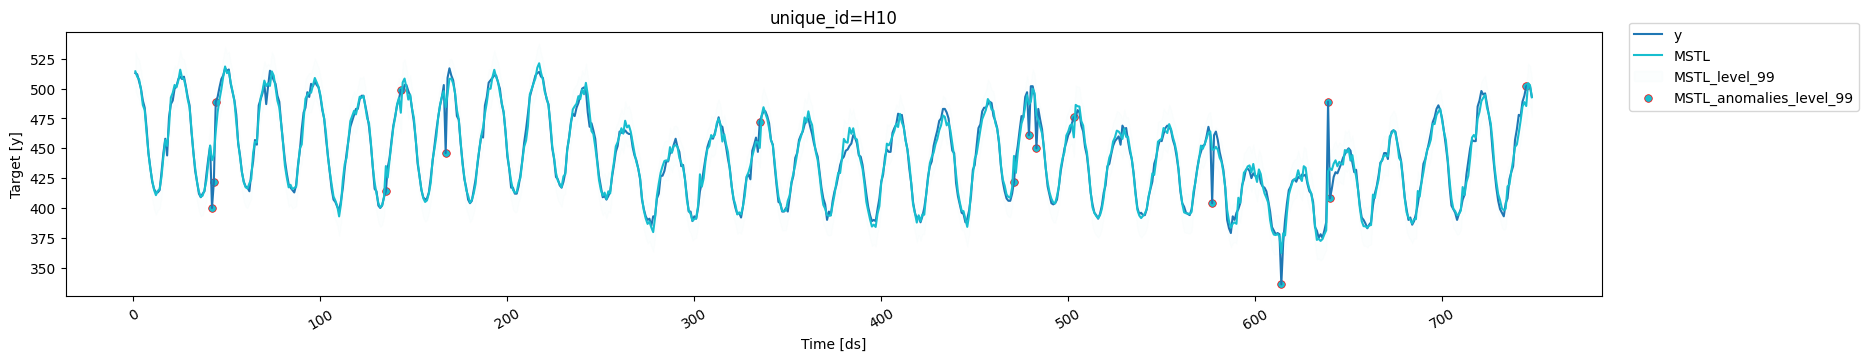

In [ ]:
plot_series(forecasts_df=insample_forecasts, level=[99], plot_anomalies=True, ids=['H10'])

Here we identified the anomalies in the data using the MSTL model, but any [probabilistic model](https://nixtla.github.io/statsforecast/#models) from StatsForecast can be used. We also selected the 99% prediction interval of the insample forecasts, but other confidence levels can be used as well.